# Synthetic Data with interaction: recovery of relevant features

## SE3

### Data

In [1]:
from pyselect.data import jordan_se3
from ignite.utils import manual_seed

In [2]:
manual_seed(2000)
X_se3, y_se3 = jordan_se3()

Visualization

In [3]:
import matplotlib.pyplot as plt
plt.style.use("../figures/pyselect.mplstyle")

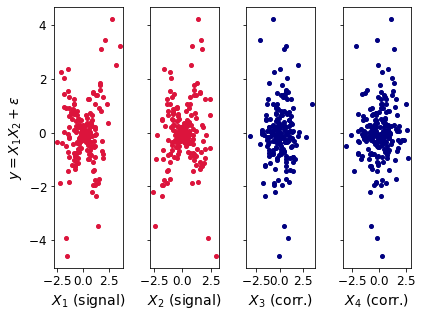

In [4]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se3[:, 0], y_se3, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_se3[:, 1], y_se3, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se3[:, i], y_se3, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

### Model

In [5]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.data import train_val_test_split
from pyselect.train import ridge_loss, score_function, best_model_callback

### SE3

In [6]:
train_size = 200
val_size = 100
test_size = 100

Generate data

In [7]:
n_features = 10

In [8]:
manual_seed(0)
X_se3, y_se3 = jordan_se3(n_samples=400)

Data-splitting

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se3, y_se3, train_size, val_size, test_size)

Generate datasets

In [10]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
val = torch.utils.data.TensorDataset(X_val, y_val)

Prepare dataloaders

In [11]:
train_loader = DataLoader(train, batch_size=train_size)
test_loader = DataLoader(test, batch_size=test_size)
val_loader = DataLoader(val, batch_size=val_size)

Objective for optuna

In [12]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    in_features = n_features
    out_features = 50
    model = RandomFourierFeaturesNet(in_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-4, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 200
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initalize optuna study

In [13]:
tpe_sampler = TPESampler(seed=0)

In [14]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-22 14:08:22,327] A new study created in memory with name: no-name-8356f666-92d2-4125-b144-2bd169aa8271


Run study

In [15]:
n_epochs = 1001

In [16]:
study.optimize(objective, n_trials=20, callbacks=[best_model_callback])

Training - Epoch: 200 Loss: 1.01944
Validation - Epoch: 200 Loss: 0.49020
Learning rate: 0.0125
Training - Epoch: 400 Loss: 0.92410
Validation - Epoch: 400 Loss: 0.46905
Learning rate: 0.0125
Training - Epoch: 600 Loss: 0.79864
Validation - Epoch: 600 Loss: 0.40594
Learning rate: 0.0063
Training - Epoch: 800 Loss: 0.71196
Validation - Epoch: 800 Loss: 0.35168
Learning rate: 0.0063


[I 2022-02-22 14:08:26,570] Trial 0 finished with value: 0.3024235153198242 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 1.3981961408994034e-05}. Best is trial 0 with value: 0.3024235153198242.


Training - Epoch: 1000 Loss: 0.63604
Validation - Epoch: 1000 Loss: 0.30254
Learning rate: 0.0031
Training - Epoch: 200 Loss: 1.08443
Validation - Epoch: 200 Loss: 0.51159
Learning rate: 0.0161
Training - Epoch: 400 Loss: 1.04616
Validation - Epoch: 400 Loss: 0.50669
Learning rate: 0.0161
Training - Epoch: 600 Loss: 0.97798
Validation - Epoch: 600 Loss: 0.50511
Learning rate: 0.0080
Training - Epoch: 800 Loss: 0.95412
Validation - Epoch: 800 Loss: 0.51319
Learning rate: 0.0080


[I 2022-02-22 14:08:28,412] Trial 1 finished with value: 0.5177351760864258 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 4.311710058685494e-06}. Best is trial 0 with value: 0.3024235153198242.


Training - Epoch: 1000 Loss: 0.93345
Validation - Epoch: 1000 Loss: 0.51773
Learning rate: 0.0040
Training - Epoch: 200 Loss: 1.08943
Validation - Epoch: 200 Loss: 0.50914
Learning rate: 0.0070
Training - Epoch: 400 Loss: 1.08124
Validation - Epoch: 400 Loss: 0.50710
Learning rate: 0.0070
Training - Epoch: 600 Loss: 1.06055
Validation - Epoch: 600 Loss: 0.50040
Learning rate: 0.0035
Training - Epoch: 800 Loss: 1.03439
Validation - Epoch: 800 Loss: 0.49181
Learning rate: 0.0035


[I 2022-02-22 14:08:30,463] Trial 2 finished with value: 0.4817397689819336 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 8.66327976135455e-06}. Best is trial 0 with value: 0.3024235153198242.


Training - Epoch: 1000 Loss: 1.00226
Validation - Epoch: 1000 Loss: 0.48177
Learning rate: 0.0018
Training - Epoch: 200 Loss: 1.08001
Validation - Epoch: 200 Loss: 0.50566
Learning rate: 0.0075
Training - Epoch: 400 Loss: 1.04926
Validation - Epoch: 400 Loss: 0.49750
Learning rate: 0.0075
Training - Epoch: 600 Loss: 1.02384
Validation - Epoch: 600 Loss: 0.49397
Learning rate: 0.0038
Training - Epoch: 800 Loss: 1.00801
Validation - Epoch: 800 Loss: 0.49347
Learning rate: 0.0038


[I 2022-02-22 14:08:32,394] Trial 3 finished with value: 0.4921870803833008 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 4.7349893044994796e-05}. Best is trial 0 with value: 0.3024235153198242.


Training - Epoch: 1000 Loss: 0.98948
Validation - Epoch: 1000 Loss: 0.49219
Learning rate: 0.0019
Training - Epoch: 200 Loss: 0.67113
Validation - Epoch: 200 Loss: 0.36188
Learning rate: 0.0846
Training - Epoch: 400 Loss: 0.16436
Validation - Epoch: 400 Loss: 0.04423
Learning rate: 0.0846
Training - Epoch: 600 Loss: 0.10152
Validation - Epoch: 600 Loss: 0.03598
Learning rate: 0.0423
Training - Epoch: 800 Loss: 0.08266
Validation - Epoch: 800 Loss: 0.03388
Learning rate: 0.0423


[I 2022-02-22 14:08:34,230] Trial 4 finished with value: 0.03233383893966675 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 1.4135935551752292e-06}. Best is trial 4 with value: 0.03233383893966675.


Training - Epoch: 1000 Loss: 0.07080
Validation - Epoch: 1000 Loss: 0.03234
Learning rate: 0.0211
Training - Epoch: 200 Loss: 0.75639
Validation - Epoch: 200 Loss: 0.38399
Learning rate: 0.0383
Training - Epoch: 400 Loss: 0.49096
Validation - Epoch: 400 Loss: 0.27435
Learning rate: 0.0383
Training - Epoch: 600 Loss: 0.38876
Validation - Epoch: 600 Loss: 0.21758
Learning rate: 0.0192
Training - Epoch: 800 Loss: 0.34068
Validation - Epoch: 800 Loss: 0.18566
Learning rate: 0.0192


[I 2022-02-22 14:08:36,272] Trial 5 finished with value: 0.1582457447052002 and parameters: {'learning_rate': 0.03832216850492789, 'reg_param': 3.860866271460544e-06}. Best is trial 4 with value: 0.03233383893966675.


Training - Epoch: 1000 Loss: 0.30269
Validation - Epoch: 1000 Loss: 0.15831
Learning rate: 0.0096


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:36,664] Trial 6 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.08843


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:37,026] Trial 7 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.09245


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:37,389] Trial 8 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.09517
Training - Epoch: 200 Loss: 0.86367
Validation - Epoch: 200 Loss: 0.44293
Learning rate: 0.0360
Training - Epoch: 400 Loss: 0.32258
Validation - Epoch: 400 Loss: 0.11959
Learning rate: 0.0360
Training - Epoch: 600 Loss: 0.19609
Validation - Epoch: 600 Loss: 0.06143
Learning rate: 0.0180
Training - Epoch: 800 Loss: 0.15344
Validation - Epoch: 800 Loss: 0.04722
Learning rate: 0.0180


[I 2022-02-22 14:08:39,491] Trial 9 finished with value: 0.04020201683044434 and parameters: {'learning_rate': 0.0360009119291161, 'reg_param': 4.074144654166234e-05}. Best is trial 4 with value: 0.03233383893966675.


Training - Epoch: 1000 Loss: 0.12628
Validation - Epoch: 1000 Loss: 0.04021
Learning rate: 0.0090
Training - Epoch: 200 Loss: 0.44634
Validation - Epoch: 200 Loss: 0.22710
Learning rate: 0.0857
Training - Epoch: 400 Loss: 0.15361
Validation - Epoch: 400 Loss: 0.07522
Learning rate: 0.0857
Training - Epoch: 600 Loss: 0.10335
Validation - Epoch: 600 Loss: 0.06197
Learning rate: 0.0428
Training - Epoch: 800 Loss: 0.08631
Validation - Epoch: 800 Loss: 0.05838
Learning rate: 0.0428


[I 2022-02-22 14:08:41,631] Trial 10 finished with value: 0.05597535610198975 and parameters: {'learning_rate': 0.08568943001593249, 'reg_param': 5.773457334097196e-07}. Best is trial 4 with value: 0.03233383893966675.


Training - Epoch: 1000 Loss: 0.07504
Validation - Epoch: 1000 Loss: 0.05598
Learning rate: 0.0214
Training - Epoch: 200 Loss: 0.32434
Validation - Epoch: 200 Loss: 0.13665
Learning rate: 0.0805
Training - Epoch: 400 Loss: 0.10793
Validation - Epoch: 400 Loss: 0.03368
Learning rate: 0.0805
Training - Epoch: 600 Loss: 0.06786
Validation - Epoch: 600 Loss: 0.02436
Learning rate: 0.0402
Training - Epoch: 800 Loss: 0.05480
Validation - Epoch: 800 Loss: 0.02263
Learning rate: 0.0402


[I 2022-02-22 14:08:43,587] Trial 11 finished with value: 0.021854891777038574 and parameters: {'learning_rate': 0.08045564515992583, 'reg_param': 9.026333081421118e-07}. Best is trial 11 with value: 0.021854891777038574.


Training - Epoch: 1000 Loss: 0.04655
Validation - Epoch: 1000 Loss: 0.02186
Learning rate: 0.0201
Training - Epoch: 200 Loss: 0.47981
Validation - Epoch: 200 Loss: 0.25159
Learning rate: 0.0918
Training - Epoch: 400 Loss: 0.22420
Validation - Epoch: 400 Loss: 0.12494
Learning rate: 0.0918
Training - Epoch: 600 Loss: 0.17065
Validation - Epoch: 600 Loss: 0.10178
Learning rate: 0.0459
Training - Epoch: 800 Loss: 0.14695
Validation - Epoch: 800 Loss: 0.09152
Learning rate: 0.0459


[I 2022-02-22 14:08:45,547] Trial 12 finished with value: 0.08200601577758788 and parameters: {'learning_rate': 0.0918305045480768, 'reg_param': 8.558456661388637e-07}. Best is trial 11 with value: 0.021854891777038574.


Training - Epoch: 1000 Loss: 0.12610
Validation - Epoch: 1000 Loss: 0.08203
Learning rate: 0.0230


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:45,966] Trial 13 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.85806


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:46,391] Trial 14 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.08902


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:46,760] Trial 15 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.86177


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:47,149] Trial 16 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.07156
Training - Epoch: 200 Loss: 0.47720
Validation - Epoch: 200 Loss: 0.18284
Learning rate: 0.0650
Training - Epoch: 400 Loss: 0.19585
Validation - Epoch: 400 Loss: 0.06162
Learning rate: 0.0650
Training - Epoch: 600 Loss: 0.13330
Validation - Epoch: 600 Loss: 0.04300
Learning rate: 0.0325
Training - Epoch: 800 Loss: 0.11039
Validation - Epoch: 800 Loss: 0.03684
Learning rate: 0.0325


[I 2022-02-22 14:08:49,230] Trial 17 finished with value: 0.032880516052246095 and parameters: {'learning_rate': 0.06497006631702776, 'reg_param': 4.0857565636787524e-07}. Best is trial 11 with value: 0.021854891777038574.


Training - Epoch: 1000 Loss: 0.09478
Validation - Epoch: 1000 Loss: 0.03289
Learning rate: 0.0162


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:49,688] Trial 18 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.06229


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:08:50,071] Trial 19 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 1.08742


Get best model

In [17]:
best_model = study.user_attrs['best_model']

In [18]:
torch.save(best_model.state_dict(), '../models/jordan-se3.pth')

Replicate best_model on different datasets

In [19]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number + 1000
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se3(n_samples=test_size)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [20]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-22 14:08:50,115] A new study created in memory with name: no-name-c49909ac-b600-4379-9687-7482f7a560bf


In [21]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-22 14:08:50,127] Trial 0 finished with value: 0.6131051013451202 and parameters: {}. Best is trial 0 with value: 0.6131051013451202.
[I 2022-02-22 14:08:50,131] Trial 1 finished with value: 0.17998730402782873 and parameters: {}. Best is trial 1 with value: 0.17998730402782873.
[I 2022-02-22 14:08:50,134] Trial 2 finished with value: 0.21030807966600507 and parameters: {}. Best is trial 1 with value: 0.17998730402782873.
[I 2022-02-22 14:08:50,137] Trial 3 finished with value: 0.4595007484272205 and parameters: {}. Best is trial 1 with value: 0.17998730402782873.
[I 2022-02-22 14:08:50,140] Trial 4 finished with value: 0.1915705073364855 and parameters: {}. Best is trial 1 with value: 0.17998730402782873.
[I 2022-02-22 14:08:50,144] Trial 5 finished with value: 0.18830584606793438 and parameters: {}. Best is trial 1 with value: 0.17998730402782873.
[I 2022-02-22 14:08:50,149] Trial 6 finished with value: 0.2311389243932963 and parameters: {}. Best is trial 1 with value: 0.17

In [22]:
replication.trials_dataframe()['value'].mean()

0.31852288103764975

In [23]:
replication.trials_dataframe()['value'].std()

0.15454683325141852

### Visualization

##### Bands

In [24]:
import numpy as np

In [25]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, n_features+1)

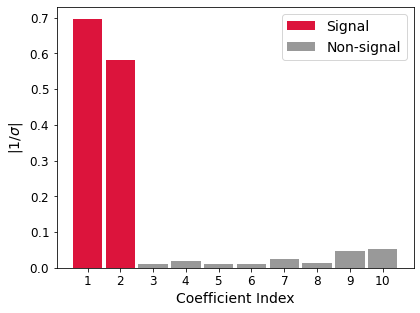

In [26]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

##### Predictions on test

In [27]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

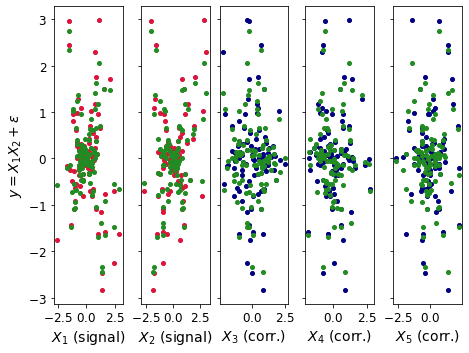

In [28]:
fig, ax = plt.subplots(ncols=5, sharey=True, constrained_layout=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()

In [29]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

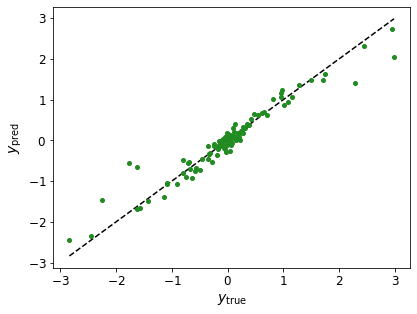

In [30]:
plt.plot(y_test, best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()